<a href="https://colab.research.google.com/github/RoetGer/decisions-under-uncertainty/blob/main/forecasting_sorrows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Sorrows Of A Young Data Scientist



In [1]:
! pip install sktime

     |████████████████████████████████| 5.7MB 5.2MB/s 
     |████████████████████████████████| 22.3MB 2.0MB/s 
     |████████████████████████████████| 9.5MB 39.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
import pandas as pd

**Imagine the following scenario**:

You are supposed to **optimize the price** of some product, e.g. the margin for FX-spot.

Let us assume that your business partners would like to optimize with respect to gross income (GI), i.e. GI = volume x price. 

Of course, volume will depend on price, so we actually have that **GI(p) = v(p) x p**, where v stands for volume.    

There is some historical pricing data which can be used to construct a model, so you feel like that a reasonable way to proceed is to fit a demand model (for the volume) and then find the price which maximizes the GI (where you use the demand model as a plug-in estimator for the volume)

To put it in a nutshell, the plan goes something like this:



1.   Fit a model, s.t. volume = f(price)
2.   Then optimize GI, i.e. f(price) x price, with respect to the price
3.   Profit

In [260]:
def get_data(seed=None, price=None):
    date_idx = pd.date_range(start="2014-01-01", end="2021-02-01")
    
    if seed:
        np.random.seed(seed)
    
    days = np.arange(date_idx.shape[0])
    annual_seas_term = 2*np.pi*days/365.25

    nterms = 5
    phase = np.random.normal(size=(nterms, 1))
    amplitude = np.random.normal(size=(nterms, 1))
    
    error = np.random.normal(scale=0.25, size=(nterms, annual_seas_term.shape[0]))
    fourier_terms = (
        amplitude * np.cos(
          np.outer(np.arange(1, 1 + nterms), annual_seas_term) + phase)
    )

    capacity = 1000*np.sqrt(np.exp(np.sum(fourier_terms + error, axis=0)))

    fourier_expert = 2.*np.cos(annual_seas_term + 2) + \
      np.random.normal(scale=.15, size=days.shape[0])
    
    if price is None:
        price_fraction = 1/(1 + np.exp(-fourier_expert))
        price = 0.1 + price_fraction*1

    volume = capacity / (1 + np.exp(-2 + 3*price))
    gi = volume * price

    return pd.DataFrame({
        "price": price,
        "volume": volume,
        "gi": gi
    }, index=date_idx)


In [243]:
date_idx = pd.date_range(start="2014-01-01", end="2021-02-01")
np.random.seed(5)
days = np.arange(date_idx.shape[0])
annual_seas_term = 2*np.pi*days/365.25

nterms = 5
phase = np.random.normal(size=(nterms, 1))
amplitude = np.random.normal(size=(nterms, 1))
error = np.random.normal(scale=0.25, size=(nterms, annual_seas_term.shape[0]))
fourier_terms = (
    amplitude * np.cos(
      np.outer(np.arange(1, 1 + nterms), annual_seas_term) + phase)
)

capacity = 1000*np.sqrt(np.exp(np.sum(fourier_terms + error, axis=0)))

fourier_expert = 2.*np.cos(annual_seas_term + 2) + \
  np.random.normal(scale=.15, size=days.shape[0])

price_fraction = 1/(1 + np.exp(-fourier_expert))
price = 0.1 + price_fraction*1

volume = capacity / (1 + np.exp(-2 + 3*price))
gi = volume * price

### Get result with highest values
alt_price = 1.1
alt_volume = capacity / (1 + np.exp(-2 + 3*alt_price))
alt_gi = alt_volume * alt_price

In [262]:
fixed_price = get_data(seed=5, price=1.1)

alt_gi.mean()

302.4476780153506

In [254]:
fixed_price.gi.mean()

302.44767801535033

In [255]:
hist_price = get_data(seed=5)

In [312]:
random_price = get_data(seed=5, price=np.random.uniform(0.1, 2.1, size=fixed_price.price.shape))
random_price.gi.mean()

238.26386270393778

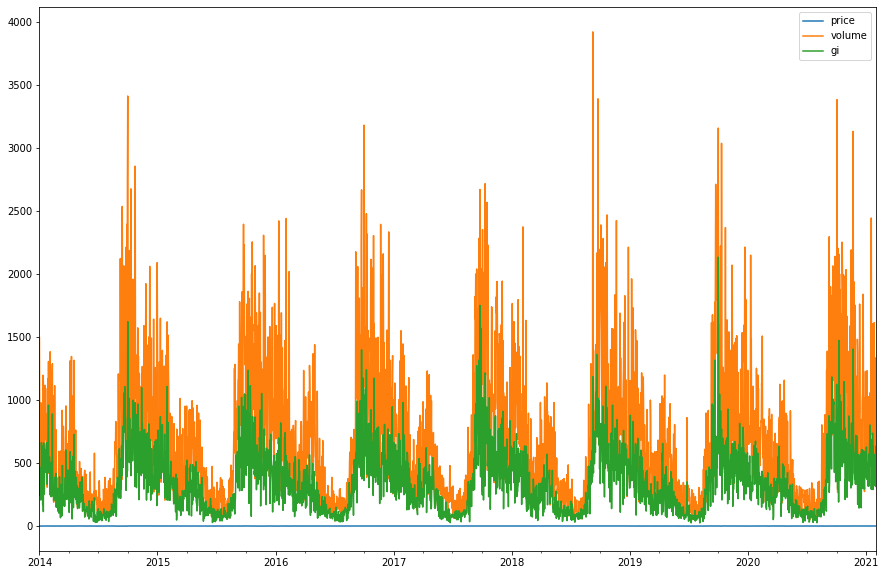

In [264]:
random_price.plot()

In [257]:
hist_price.gi.mean()

345.79639790067887

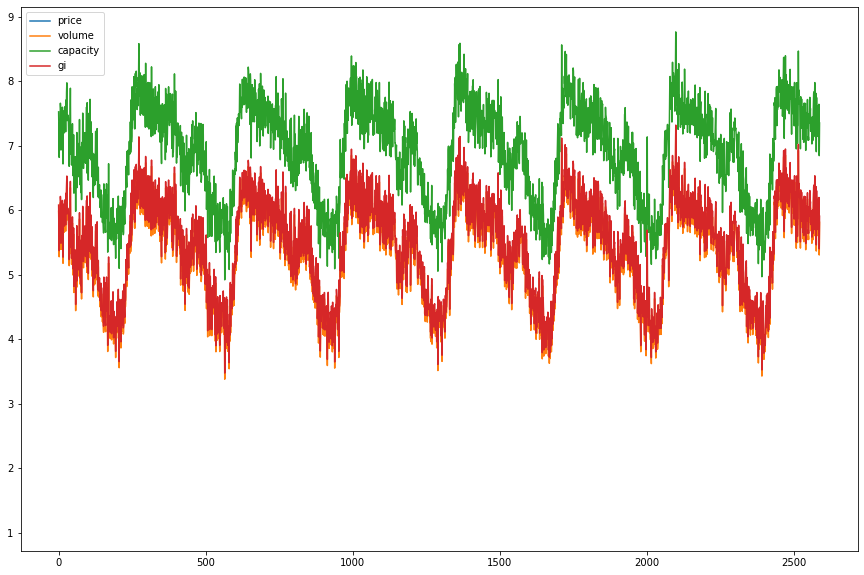

In [247]:
plt.plot(alt_price, label="price")
plt.plot(np.log(alt_volume), label="volume")
plt.plot(np.log(capacity), label="capacity")
plt.plot(np.log(alt_gi), label="gi")
plt.legend(loc="best")

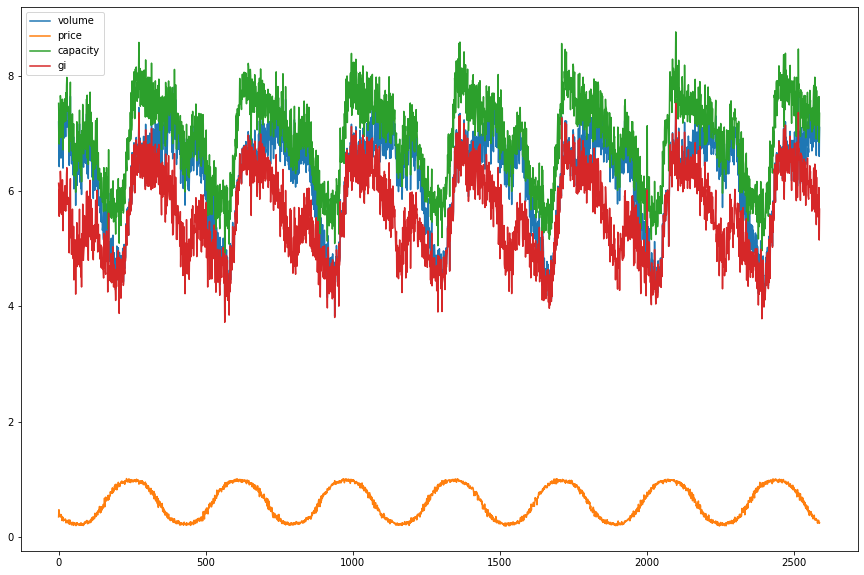

In [162]:
plt.plot(np.log(volume), label="volume")
plt.plot(price, label="price")
plt.plot(np.log(capacity), label="capacity")
plt.plot(np.log(gi), label="gi")
plt.legend(loc="best")

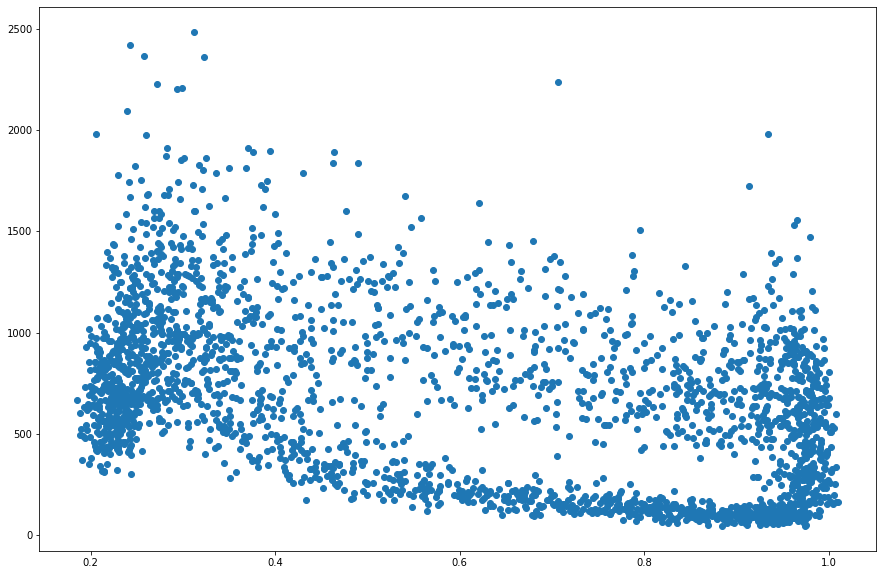

In [154]:
plt.scatter(price, volume)

In [159]:
fitted = tlr.predict(price.reshape(-1, 1))
resids = volume - fitted

In [165]:
fourier_terms.T.shape

(2589, 5)

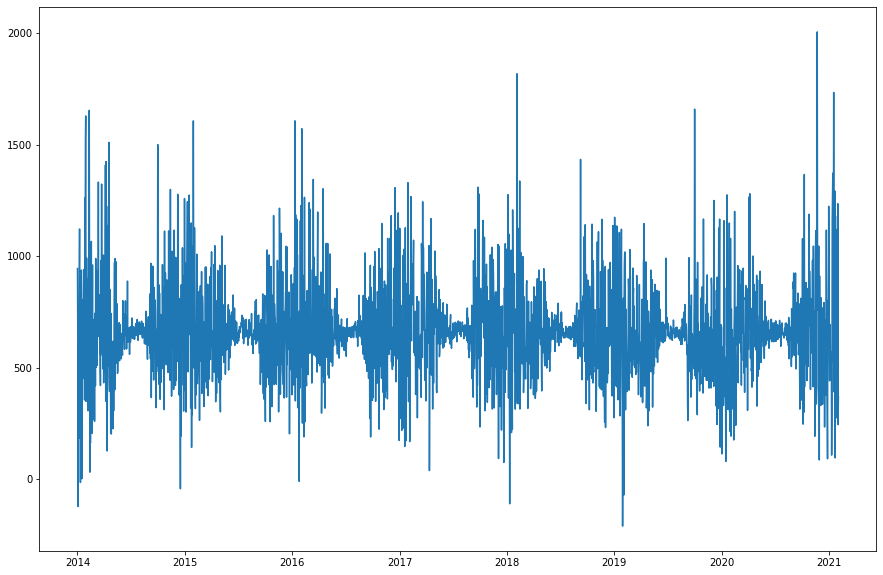

In [214]:
ts_data = pd.Series(volume, index=date_idx)

dseas = Deseasonalizer(sp=365)
dseas_volume = dseas.fit_transform(ts_data)
plt.plot(dseas_volume)

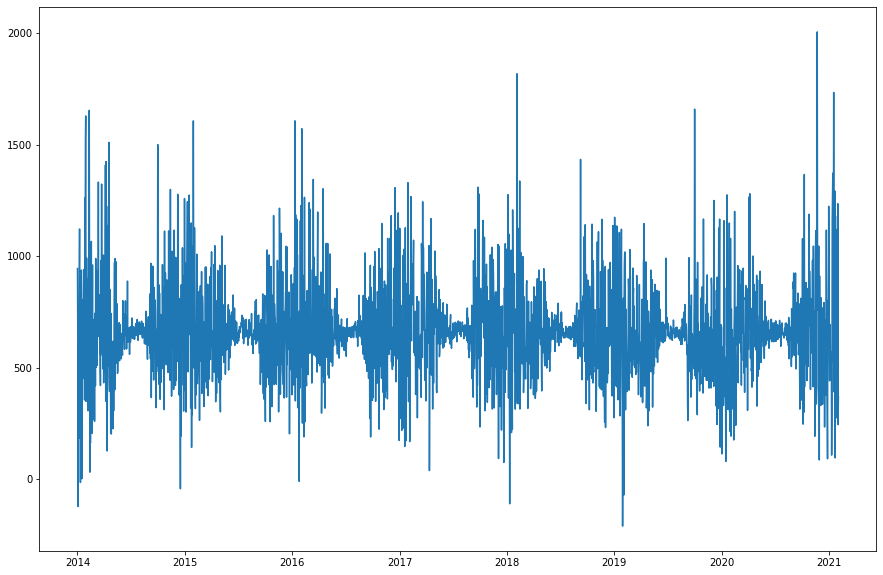

In [210]:
from sktime.transformations.series.detrend import Deseasonalizer

dseas = Deseasonalizer(sp=365)
dseas_volume = dseas.fit_transform(ts_data)
plt.plot(dseas_volume)

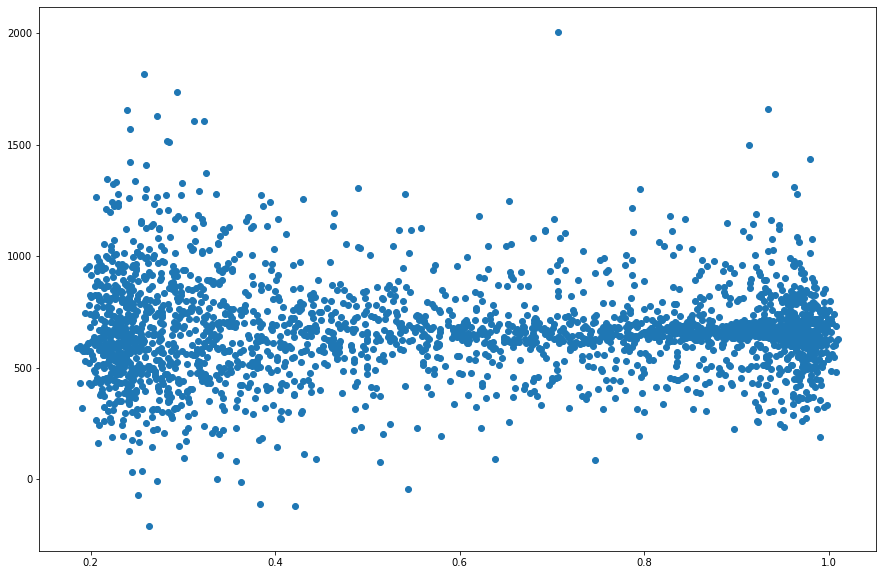

In [215]:
plt.scatter(price, dseas.fit_transform(ts_data))

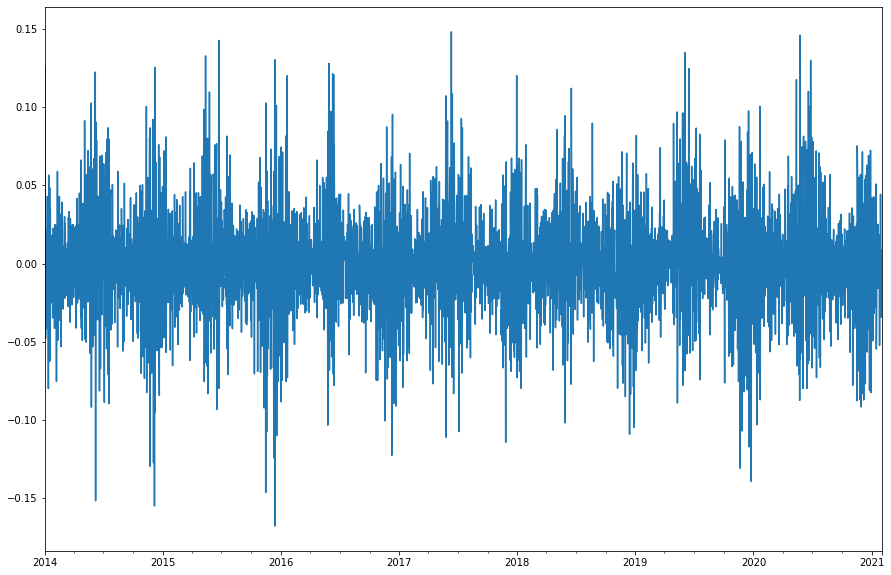

In [222]:
pd.Series(price, index=date_idx).diff().plot()

In [227]:
price_diff = pd.Series(price, index=date_idx).diff().dropna()

AttributeError: ignored

In [230]:
volume_df = dseas.fit_transform(ts_data)[price_diff.index]

In [231]:
import statsmodels.api as sm

res = sm.OLS(price_diff, volume_df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.9488
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                       0.330
Time:                        20:02:53   Log-Likelihood:                          4765.5
No. Observations:                2588   AIC:                                     -9529.
Df Residuals:                    2587   BIC:                                     -9523.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.056e-06   1.08e-06     -0.974      0.330   -3.18e-06    1.07e-06
==============================================================================
Omnibus:                       59.988   Durbin-Watson:                   2.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.090
Skew:                           0.033   Prob(JB):                     1.26e-29
Kurtosis:                       4.109   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [239]:
volume_diff = dseas.fit_transform(ts_data).diff().dropna()
volume_diff

2014-01-02   -325.826490
2014-01-03   -739.689425
2014-01-04    738.308585
2014-01-05   -194.726610
2014-01-06     78.650293
                 ...    
2021-01-28   -575.055809
2021-01-29    118.260507
2021-01-30    827.325014
2021-01-31   -989.466410
2021-02-01    124.986325
Freq: D, Length: 2588, dtype: float64

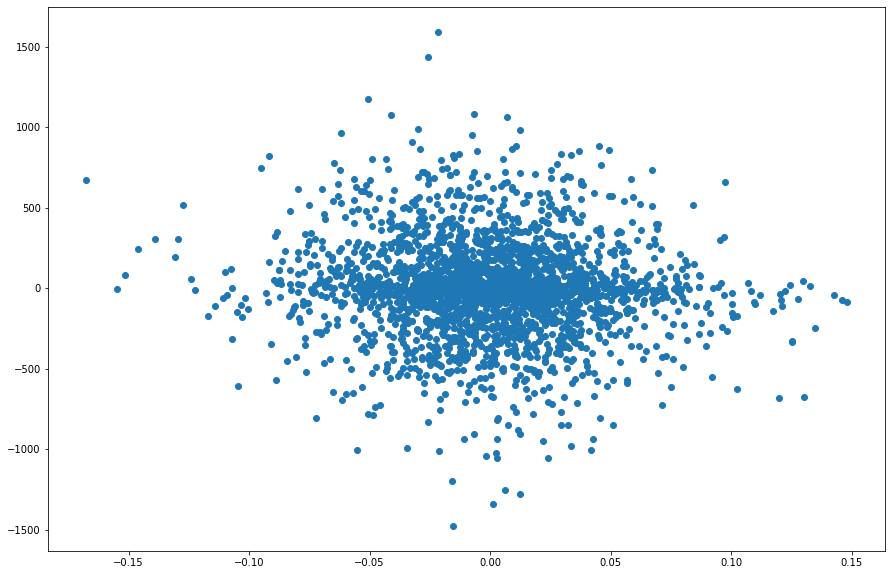

In [240]:
plt.scatter(price_diff, volume_diff)

In [241]:
res = sm.OLS(price_diff, volume_diff).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              16.33
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                    5.48e-05
Time:                        20:19:20   Log-Likelihood:                          4773.2
No. Observations:                2588   AIC:                                     -9544.
Df Residuals:                    2587   BIC:                                     -9538.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.024e-05   2.53e-06     -4.041      0.000   -1.52e-05   -5.27e-06
==============================================================================
Omnibus:                       56.607   Durbin-Watson:                   2.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.202
Skew:                           0.032   Prob(JB):                     2.91e-27
Kurtosis:                       4.063   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [242]:
price_diff

2014-01-02    0.125388
2014-01-03   -0.047834
2014-01-04   -0.042367
2014-01-05   -0.017327
2014-01-06    0.021229
                ...   
2021-01-28    0.044177
2021-01-29   -0.003725
2021-01-30   -0.015449
2021-01-31   -0.034390
2021-02-01    0.008599
Freq: D, Length: 2588, dtype: float64

In [313]:
random_price = get_data(seed=5, price=np.random.uniform(0.1, 2.1, size=fixed_price.price.shape))
random_price["log_volume"] = np.log(random_price.volume)

In [295]:
dseas = Deseasonalizer(sp=365)
random_price["deseas_volume"] = dseas.fit_transform(random_price.volume)
random_price["deseas_volume"] = 
random_price_diff = random_price.diff().dropna()

In [323]:
random_price["deseas_log_volume"] = dseas.fit_transform(random_price.log_volume)
random_price["deseas_volume"] = dseas.fit_transform(random_price.volume)

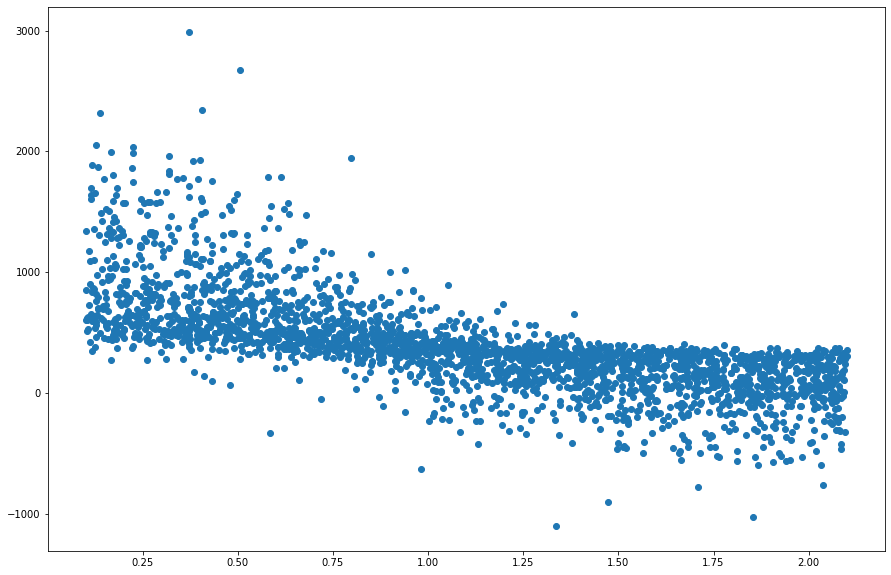

In [324]:
plt.scatter(random_price.price, random_price.deseas_volume)

In [325]:
sm.OLS(random_price.deseas_volume, sm.add_constant(random_price.price)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          deseas_volume   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     2579.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:55:28   Log-Likelihood:                -18314.
No. Observations:                2589   AIC:                         3.663e+04
Df Residuals:                    2587   BIC:                         3.664e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        928.8315     12.042     77.131      0.000     905.218     952.445
price       -490.9298      9.668    -50.781      0.000    -509.887    -471.973
==============================================================================
Omnibus:                      617.316   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3121.865
Skew:                           1.041   Prob(JB):                         0.00
Kurtosis:                       7.960   Cond. No.                         4.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [320]:
??sm.OLS

In [315]:
sm.OLS(random_price.deseas_log_volume, random_price.price).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      deseas_log_volume   R-squared (uncentered):                   0.586
Model:                            OLS   Adj. R-squared (uncentered):              0.585
Method:                 Least Squares   F-statistic:                              3656.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:50:13   Log-Likelihood:                         -6833.4
No. Observations:                2589   AIC:                                  1.367e+04
Df Residuals:                    2588   BIC:                                  1.367e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price          3.2335      0.053     60.466      0.000       3.129       3.338
==============================================================================
Omnibus:                     1407.046   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.208
Skew:                          -0.177   Prob(JB):                     1.98e-34
Kurtosis:                       1.854   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

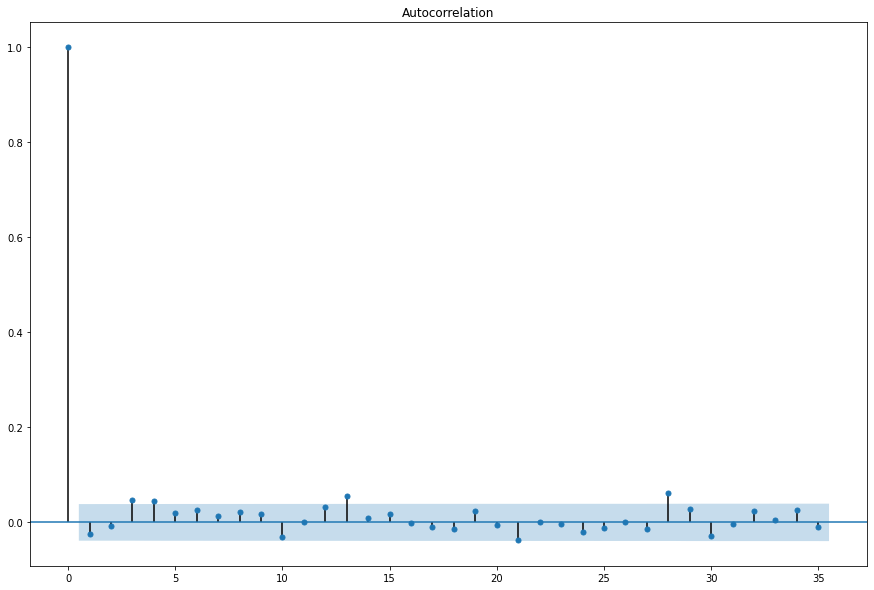

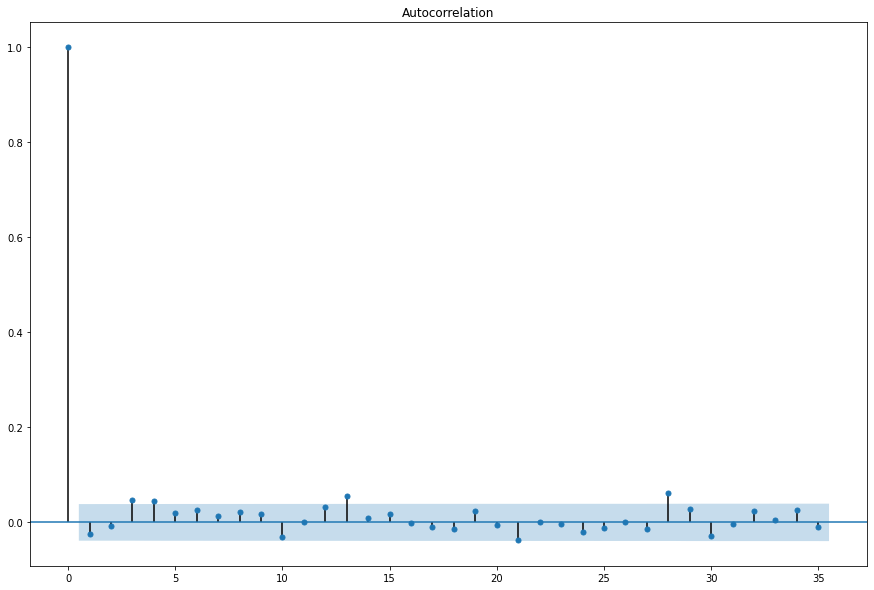

In [306]:
sm.graphics.tsa.plot_acf(random_price.deseas_log_volume)

In [301]:
sm.tsa.stattools.acf(random_price.deseas_volume)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


array([ 1.        , -0.04630416, -0.03847725,  0.03095783,  0.03187837,
        0.0148742 ,  0.01669081, -0.00414648,  0.01490151, -0.00746017,
       -0.05961213,  0.00232952,  0.02615526,  0.00631455, -0.01397051,
       -0.03089385,  0.03826036, -0.03214941, -0.00405935, -0.01314927,
       -0.00804356, -0.05538943,  0.00784014, -0.01950574, -0.00170291,
       -0.00897524, -0.00105902, -0.0053424 ,  0.04130438,  0.01164572,
       -0.02131665, -0.00435703,  0.01654067,  0.01958918,  0.01396325,
        0.0059714 ,  0.04461911, -0.01270585, -0.00968416,  0.00376328,
        0.02158068])

In [298]:
sm.tsa.stattools.adfuller(random_price.deseas_volume)

(-24.823812373568238,
 0.0,
 3,
 2585,
 {'1%': -3.4328822265006687,
  '10%': -2.5673655460943023,
  '5%': -2.862658740388024},
 37277.28443861426)

In [297]:
mdl = sm.OLS(random_price_diff.deseas_volume, random_price_diff.price).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          deseas_volume   R-squared (uncentered):                   0.344
Model:                            OLS   Adj. R-squared (uncentered):              0.344
Method:                 Least Squares   F-statistic:                              1360.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                   1.48e-239
Time:                        21:02:23   Log-Likelihood:                         -19254.
No. Observations:                2588   AIC:                                  3.851e+04
Df Residuals:                    2587   BIC:                                  3.852e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price       -725.6139     19.679    -36.872      0.000    -764.202    -687.025
==============================================================================
Omnibus:                      296.850   Durbin-Watson:                   3.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2677.952
Skew:                           0.124   Prob(JB):                         0.00
Kurtosis:                       7.977   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

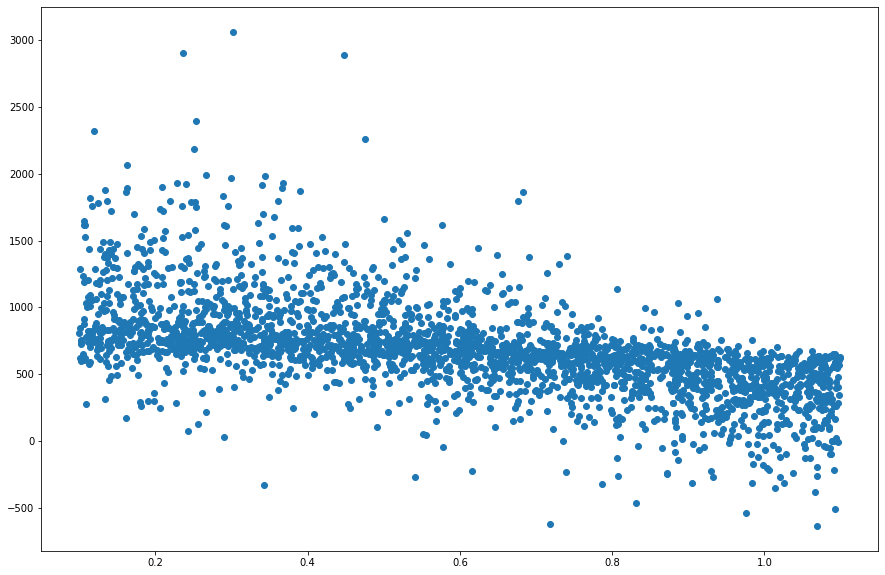

In [288]:
plt.scatter(random_price.price, random_price.deseas_volume)

In [294]:
mdl.predict(np.arange(10))

array([   0.        ,  789.68082644, 1579.36165289, 2369.04247933,
       3158.72330578, 3948.40413222, 4738.08495867, 5527.76578511,
       6317.44661155, 7107.127438  ])

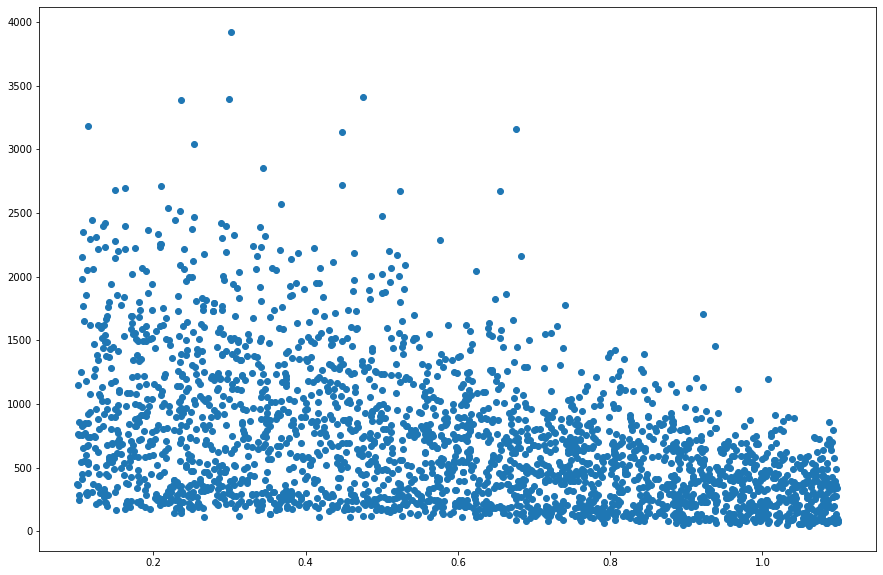

In [270]:
plt.scatter(random_price.price, random_price.volume)

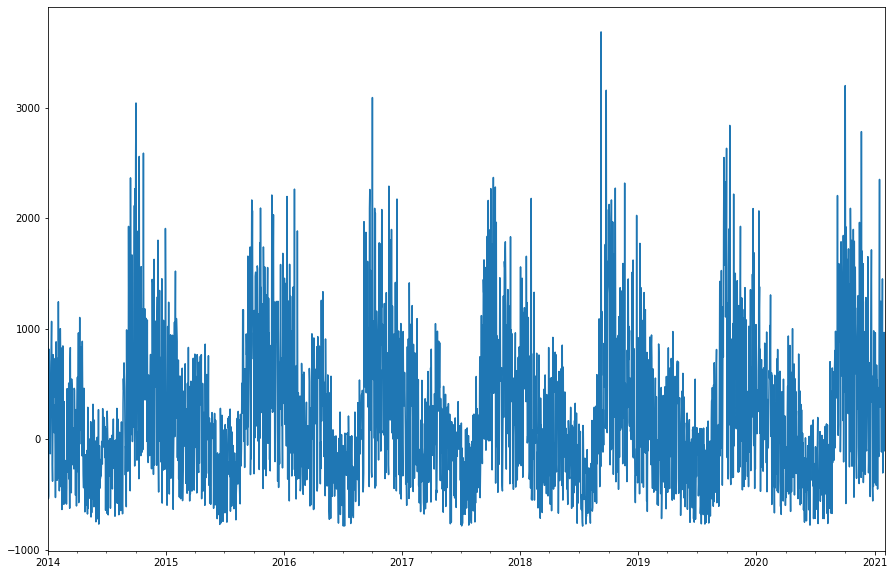

In [281]:
res = sm.OLS(random_price.volume, random_price.price).fit()
res.resid.plot()

In [ ]:
plt.plot()

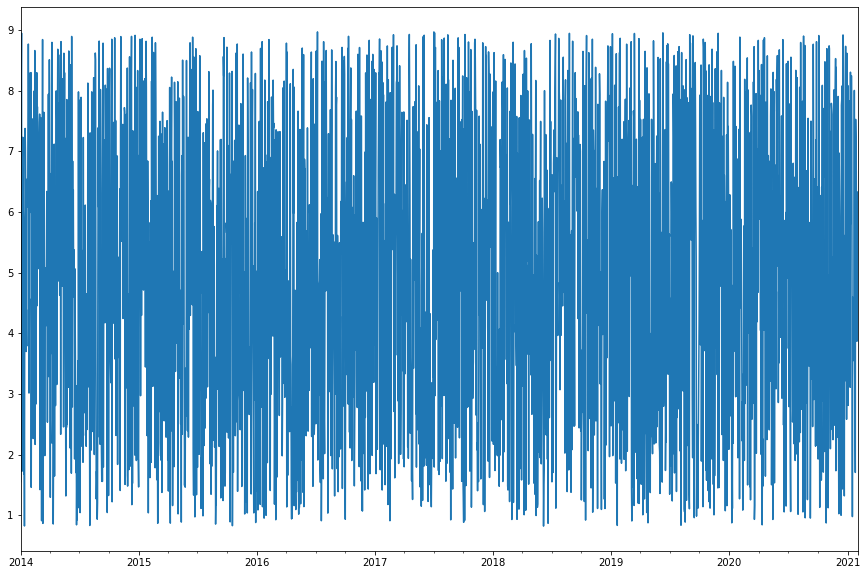

In [278]:
res.fittedvalues.plot()

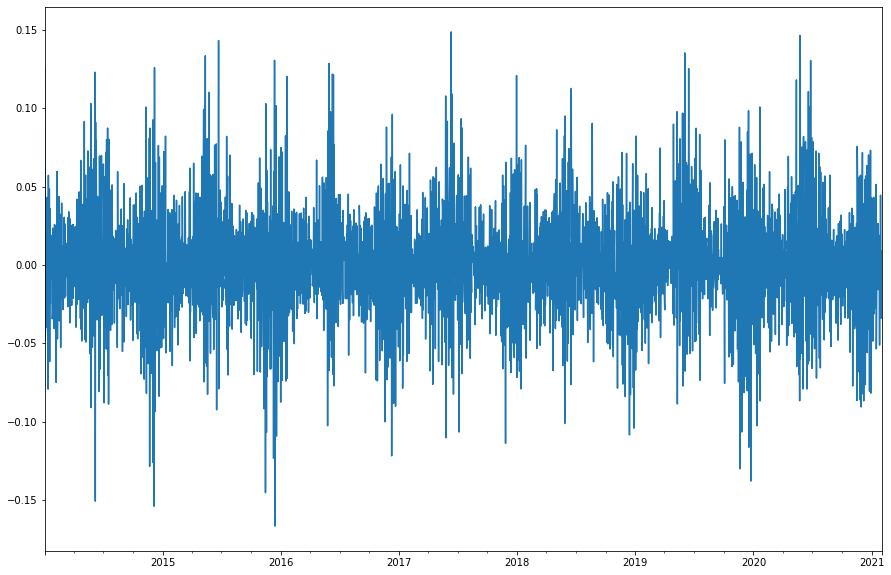

In [233]:
res.resid.plot()

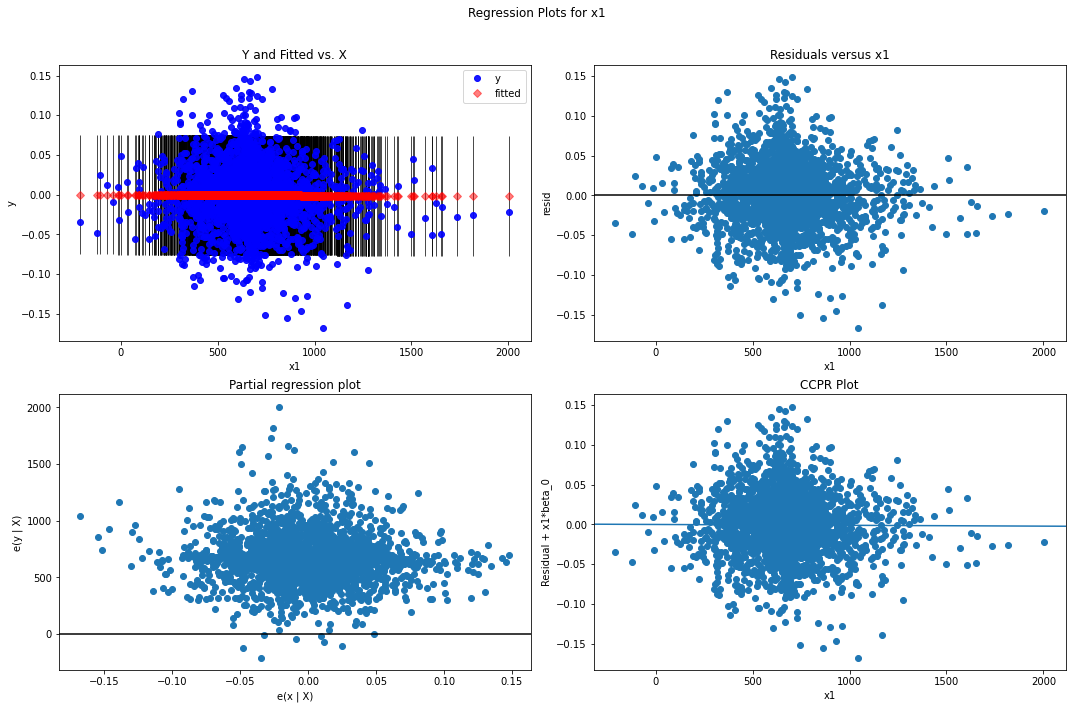

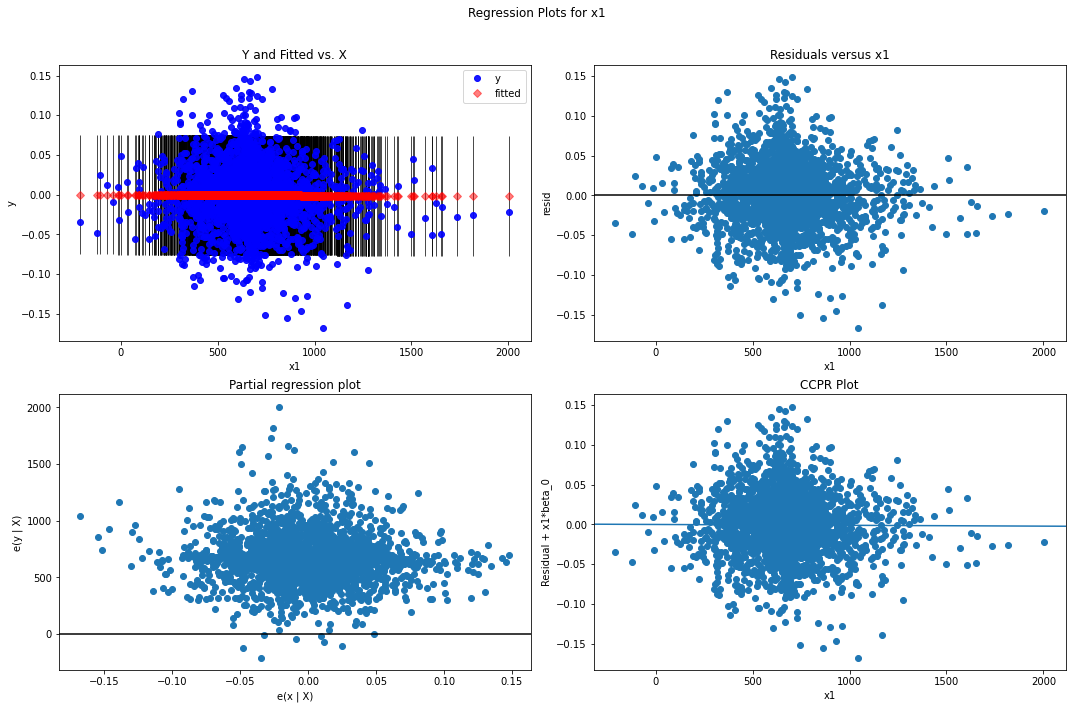

In [237]:
sm.graphics.plot_regress_exog(res, "x1")

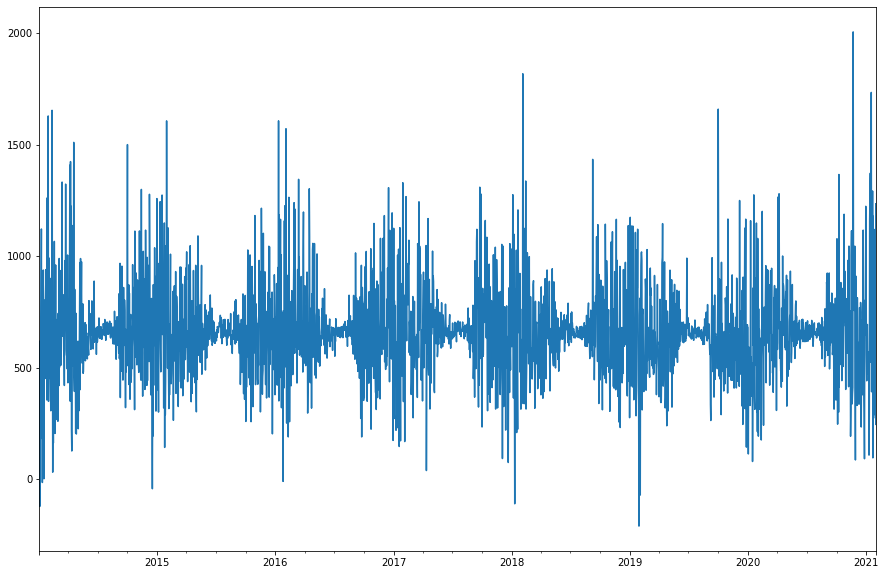

In [234]:
volume_df.plot()

In [ ]:
import statsmodels.api as sm

res = sm.OLS(price_diff, volume_df).fit()
res.summary()

In [284]:
sm.tsa.seasonal_decompose(ts_data, period=365)

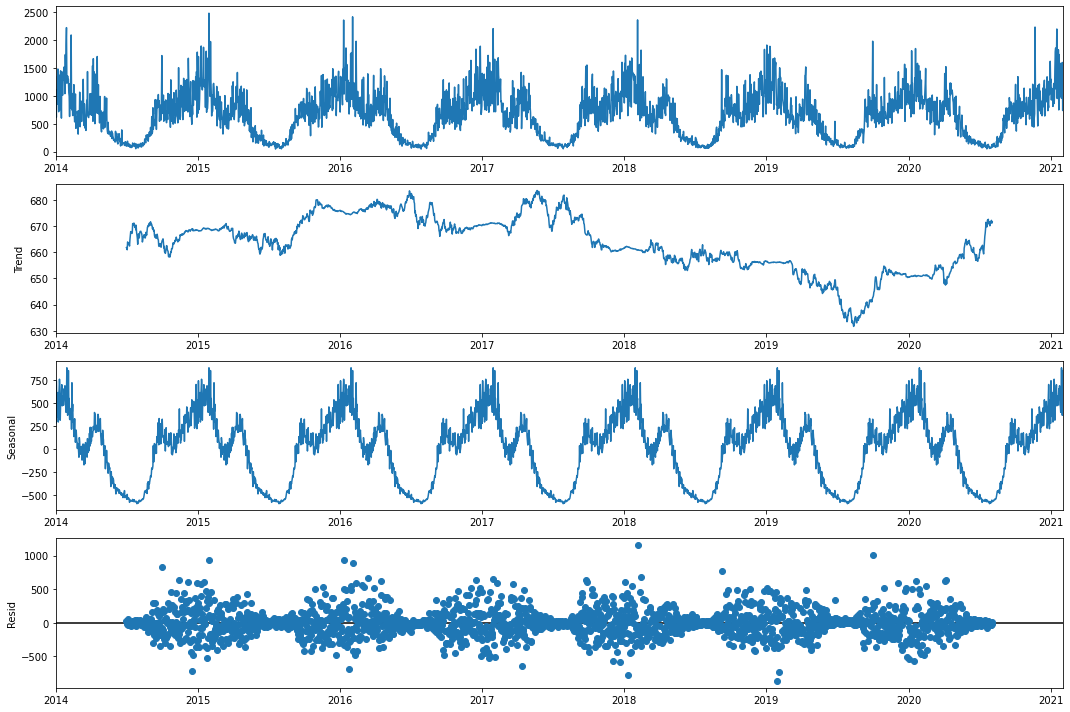

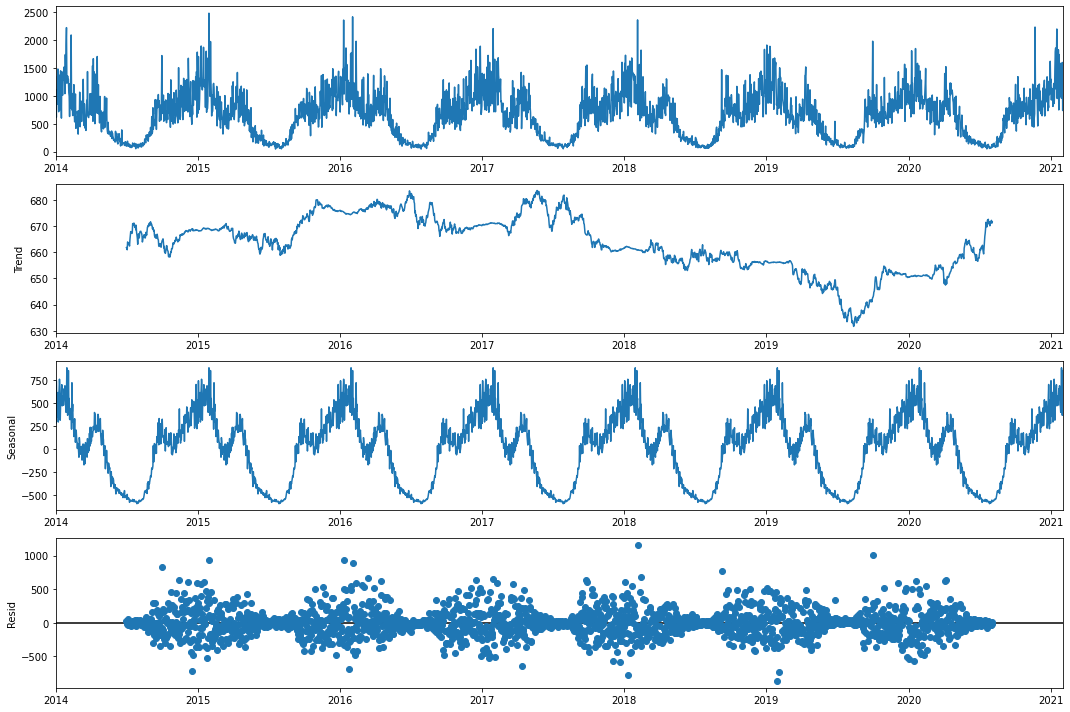

In [218]:
sm.tsa.seasonal_decompose(ts_data, period=365).plot()

In [207]:
??sm.tsa.seasonal_decompose(ts_data, period=365).plot

In [197]:
sm.tsa.stattools.adfuller(price)

(-10.052420242534119,
 1.4011709178184694e-17,
 28,
 2560,
 {'1%': -3.4329069801374077,
  '10%': -2.5673713661193847,
  '5%': -2.862669671881199},
 -10902.396988258457)

In [192]:
??sm.tsa.stattools.adfuller

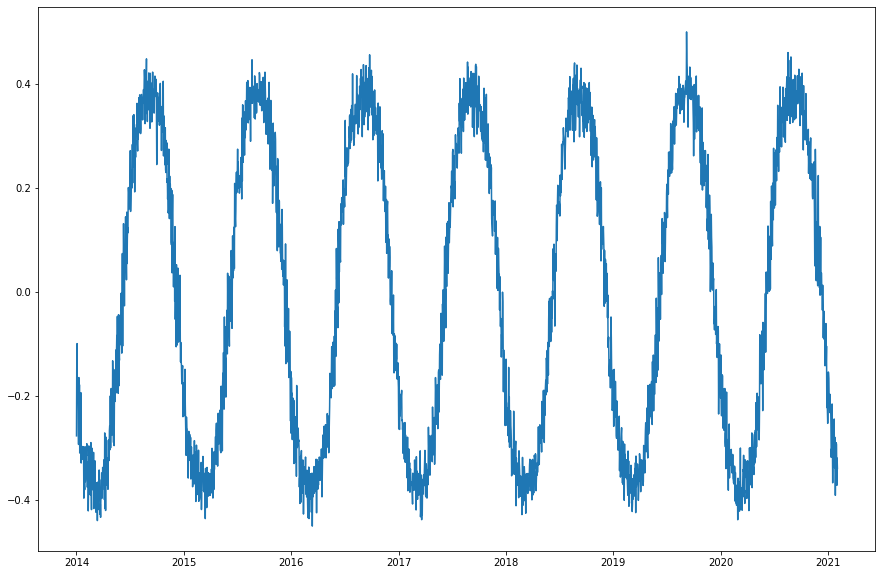

In [189]:
plt.plot(res.resid)

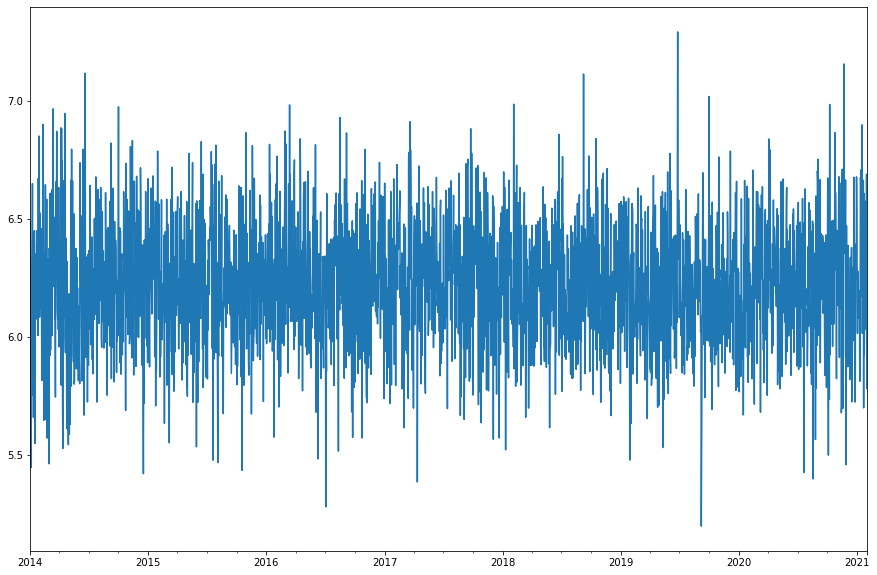

In [183]:
dseas.fit_transform(ts_data).plot()

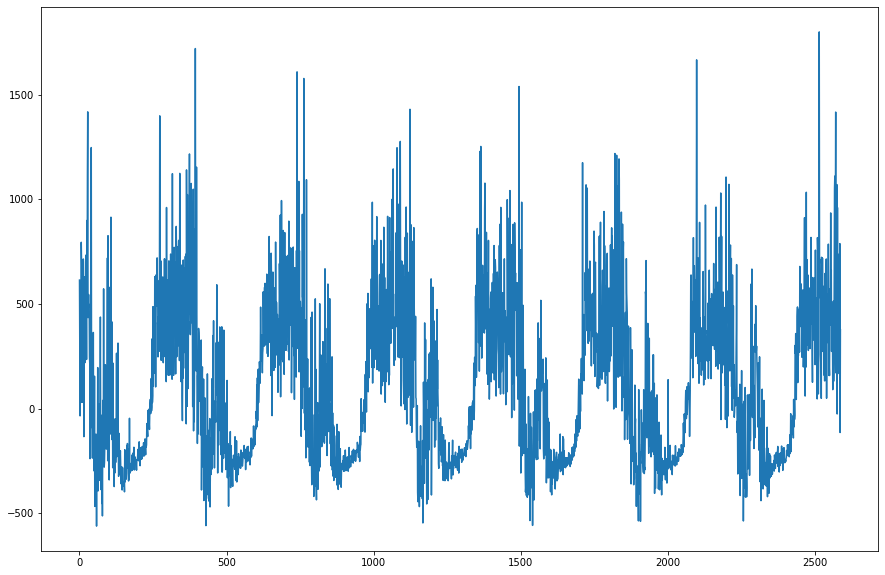

In [160]:
plt.plot(resids)

In [150]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
lr = LinearRegression()

tlr = TransformedTargetRegressor(
    regressor=lr,
    transformer=log_transformer)

In [ ]:
Function

In [151]:
tlr.fit(price.reshape(-1, 1), volume)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=FunctionTransformer(func=<ufunc 'log'>,
                                                           inverse_func=<ufunc 'exp'>))

In [153]:
tlr.regressor_.coef_

array([-1.41976474])

In [133]:
1.853/(1 + np.exp(-2. + 3*0.2))

1.4864467454990518

In [115]:
1/(1 + np.exp(-0.1*2.))

0.549833997312478

In [132]:
fourier_expert = 2.*np.cos(days*2*np.pi/365.25 + 2) + np.random.normal(scale=.15, size=days.shape[0])
price_fraction = 1/(1 + np.exp(-fourier_expert))

price = 0.1 + price_fraction*1.25

print(np.min(price), np.max(price))

0.20972902762552675 1.249716156529258


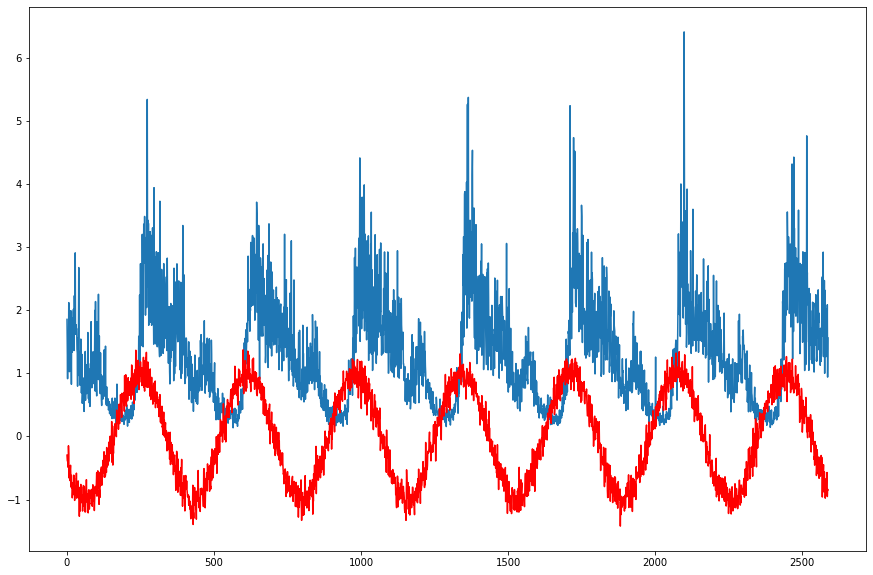

In [87]:
plt.plot(np.sqrt(np.exp(np.sum(fourier_terms, axis=0))))
fourier_expert = np.cos(days*2*np.pi/365.25 + 2) + np.random.normal(scale=.15, size=days.shape[0])
#price = 

plt.plot(fourier_expert, color="red")

In [38]:
??plt.plot

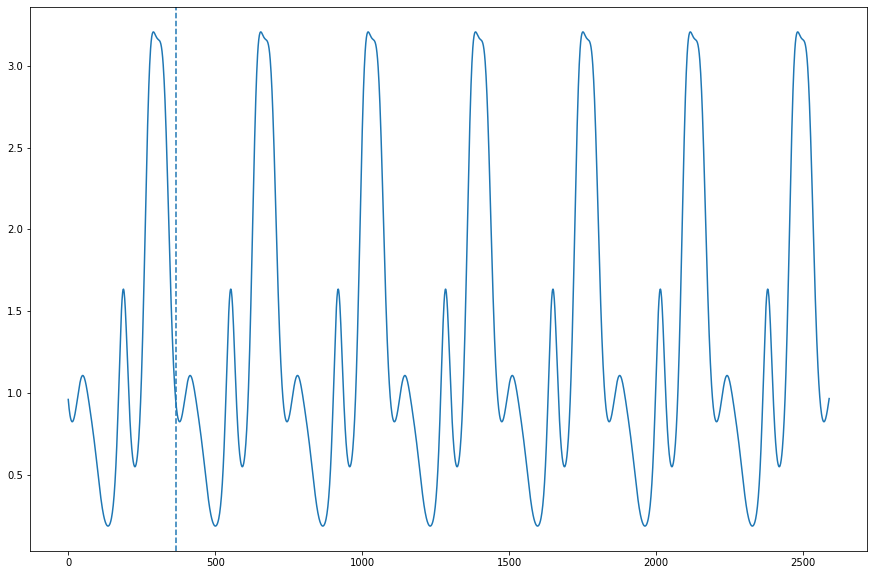

In [39]:
plt.plot(np.sqrt(np.exp(np.sum(fourier_terms, axis=0))))
plt.axvline(x=365, ymin=0, ymax=10, linestyle="--")

In [50]:
np.random.gamma(shape=0.25, size=1000).mean()

0.24998703804444533

In [53]:
np.abs(np.random.normal(scale=0.25, size=(nterms, annual_seas_term.shape[0]))).mean()

0.20127955629986904

In [48]:
np.abs(np.sum(fourier_terms, axis=0)).mean()

1.199111493678861

In [42]:
?np.random.gamma

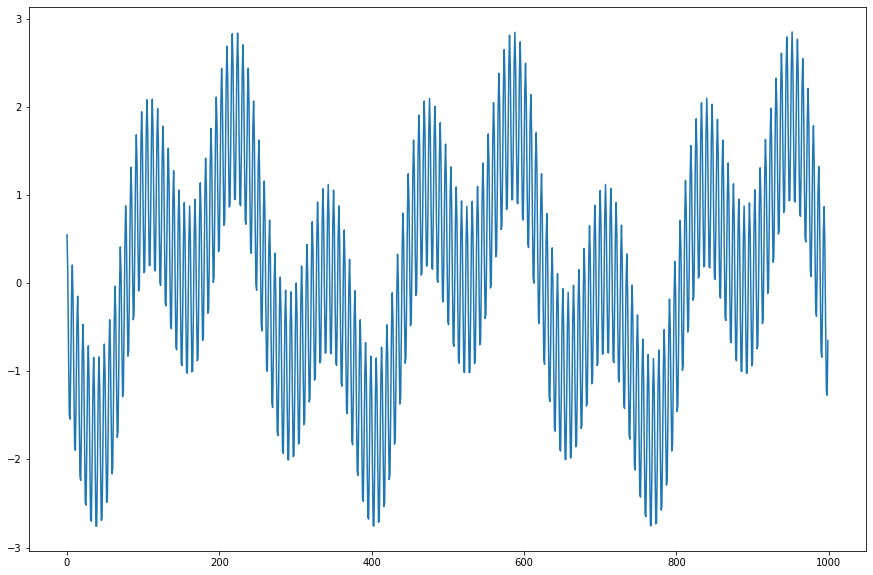

In [19]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(15, 10))

plt.plot(
    np.cos(2*np.pi*np.arange(1000)/365.25 + 3) + 
    np.cos(2*3*np.pi*np.arange(1000)/365.25 + 1) + 
    np.cos(2*np.pi*np.arange(1000)/7))

In [18]:
?plt.rc

In [ ]:
np.cos(np.arange(1000))

In [3]:
pd.date_range(start="2014-01-01", end="2021-02-01")

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2021-01-23', '2021-01-24', '2021-01-25', '2021-01-26',
               '2021-01-27', '2021-01-28', '2021-01-29', '2021-01-30',
               '2021-01-31', '2021-02-01'],
              dtype='datetime64[ns]', length=2589, freq='D')